In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Важная настройка для корректной настройки pipeline!
import sklearn
sklearn.set_config(transform_output="pandas")

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder

from sklearn.model_selection import GridSearchCV, KFold

# for model learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

#models
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from catboost import CatBoostRegressor

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error


# tunning hyperparamters model
import optuna


#### Запись данных

In [232]:
train = pd.read_csv("/home/savely/ds_bootcamp/ds-phase-1/House_Prices_project/data/train.csv")
test = pd.read_csv("/home/savely/ds_bootcamp/ds-phase-1/House_Prices_project/data/test.csv")
submission = pd.read_csv("/home/savely/ds_bootcamp/ds-phase-1/House_Prices_project/data/sample_submission.csv")

#### Информация о датафреймах

In [233]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [234]:
train.shape, test.shape

((1460, 81), (1459, 80))

In [235]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [236]:
train["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

#### Визуализация данных 

In [237]:
cat_features = train.select_dtypes(include="object")
num_features = train.select_dtypes(include=["int64", "float64"])

/home/savely/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice', ylabel='Count'>

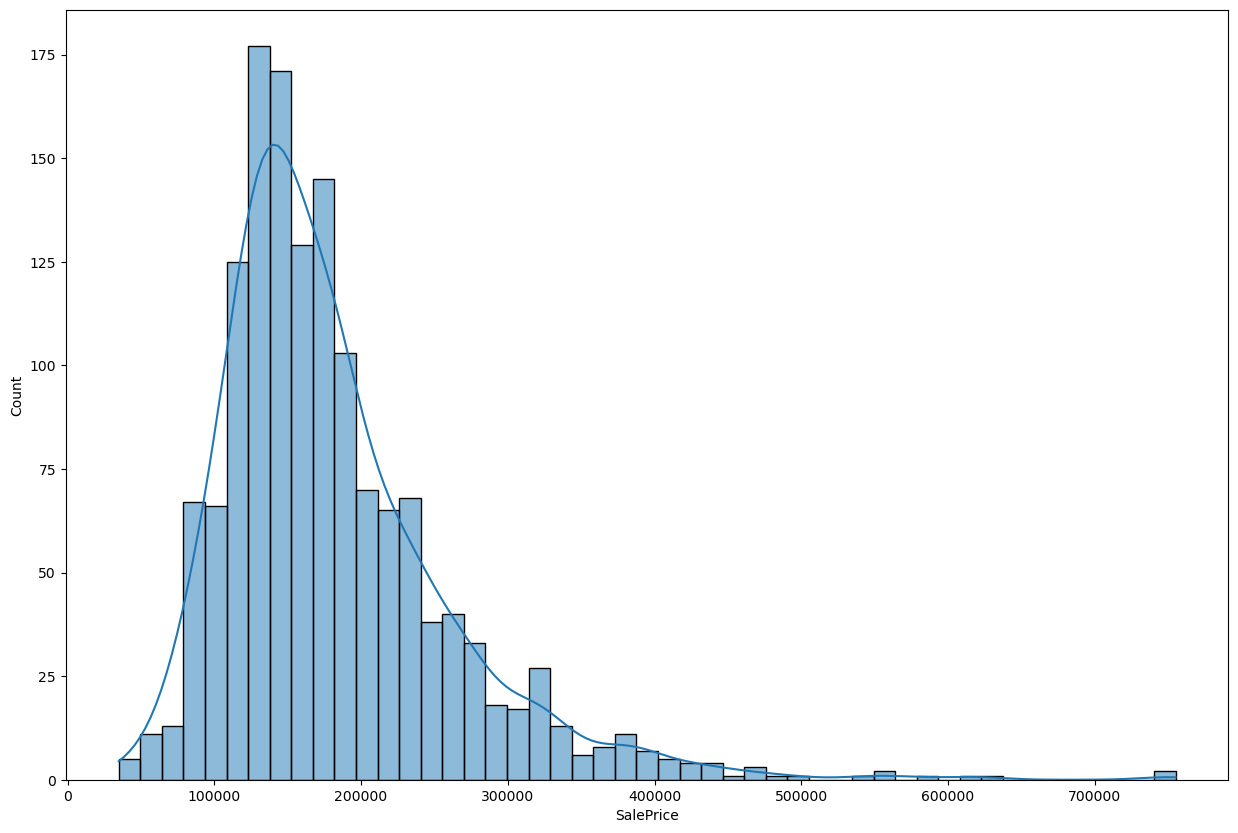

In [238]:
sns.histplot(data=train, x="SalePrice", kde=True)

/home/savely/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice', ylabel='Count'>

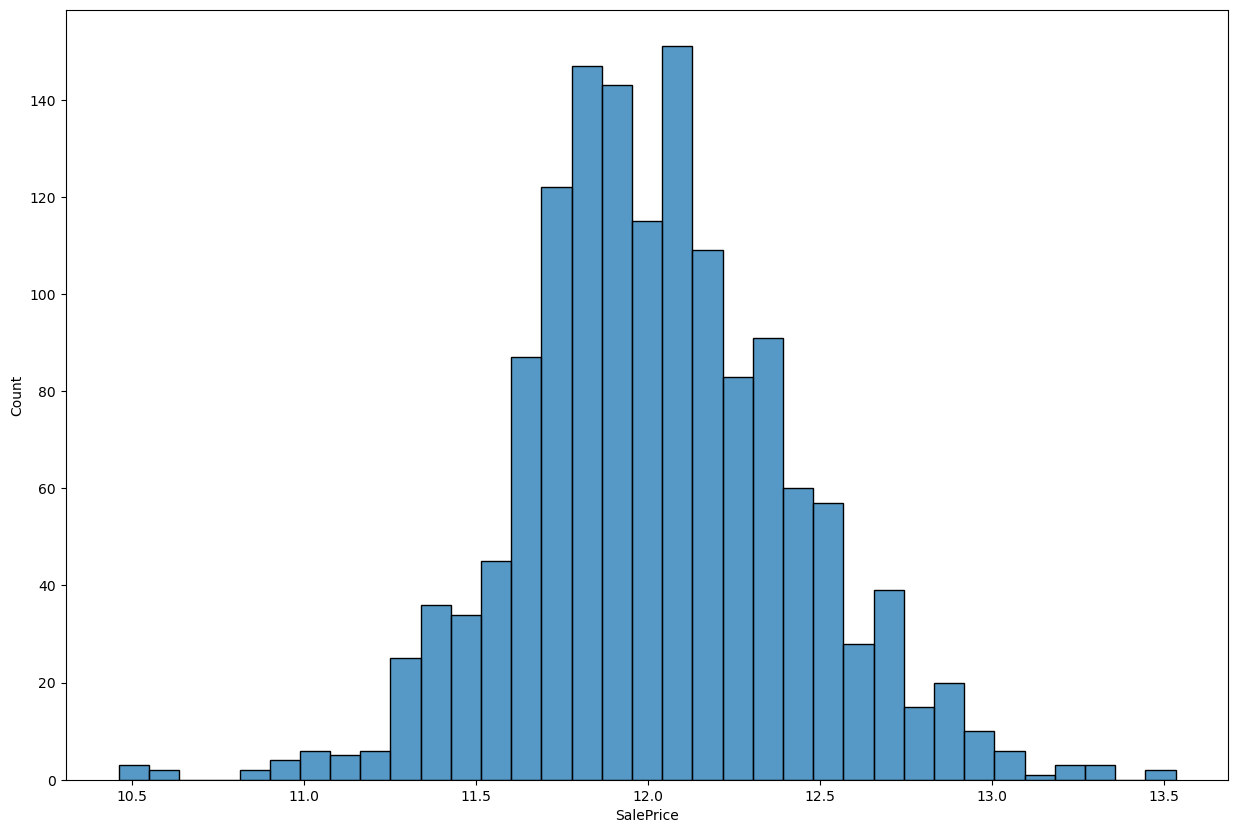

In [239]:
sns.histplot(data=train, x=np.log(train["SalePrice"]))

#### Корреляция признаков между собой и по таргету

<Axes: >

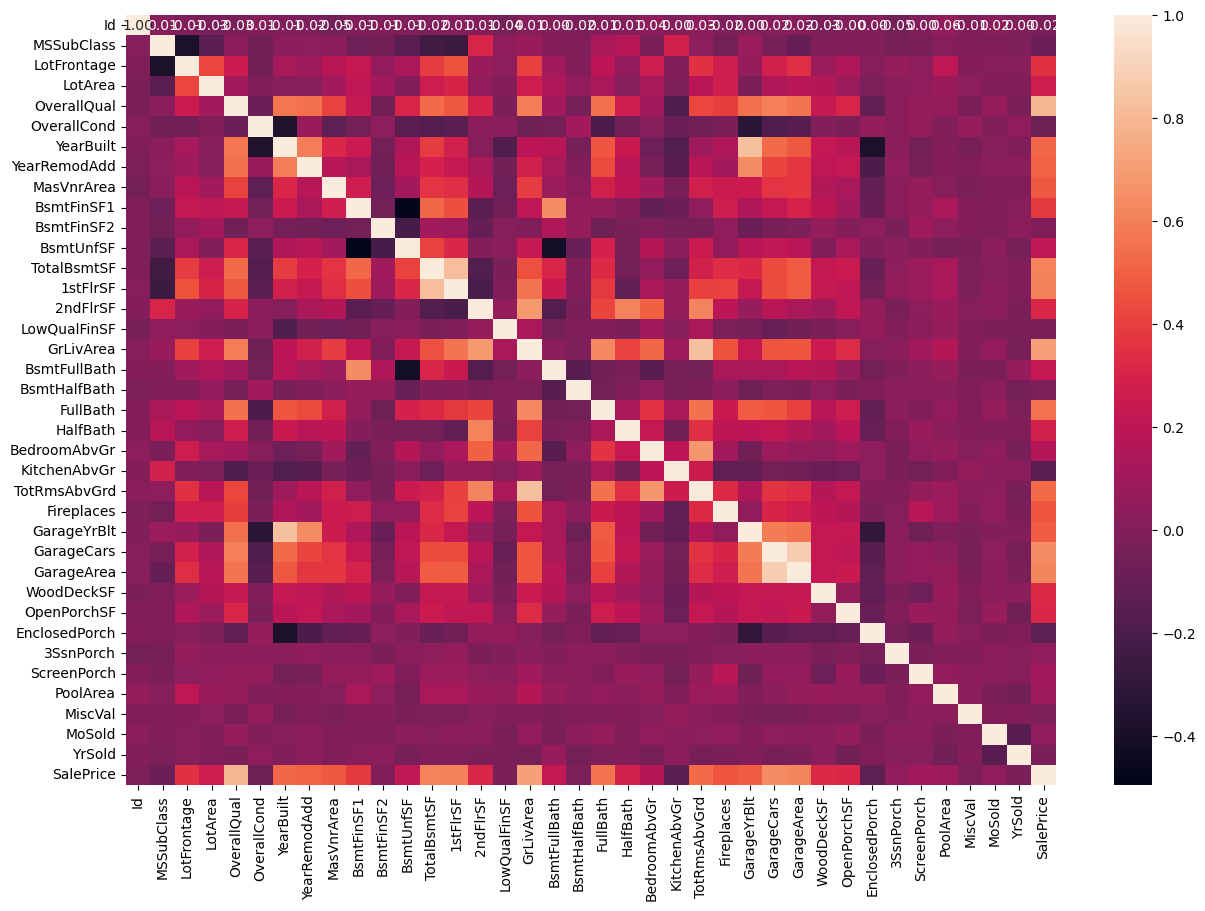

In [240]:
plt.rcParams["figure.figsize"] = [15, 10]
sns.heatmap(num_features.corr(), annot=True, fmt=".2f")

In [241]:
num_cor = num_features.corr()['SalePrice'].sort_values(ascending=False).reset_index()
num_cor

,index,SalePrice
0,SalePrice,1.000000
1,OverallQual,0.790982
2,GrLivArea,0.708624
3,GarageCars,0.640409
4,GarageArea,0.623431
5,TotalBsmtSF,0.613581
6,1stFlrSF,0.605852
7,FullBath,0.560664
8,TotRmsAbvGrd,0.533723
9,YearBuilt,0.522897


In [242]:
drop_num_features = ["MoSold", "3SsnPorch", "BsmtFinSF2", "BsmtHalfBath", "MiscVal", "Id", "LowQualFinSF", "YrSold"]

#### Объединение train и test датафреймов

In [243]:
# train['dataset'] = 'train'
# test['dataset'] = 'test'

# # Объединение DataFrame
# all_data = pd.concat([train, test], ignore_index=True)

In [244]:
X, y = train.drop("SalePrice", axis=1), train["SalePrice"]

In [245]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

#### Просмотр пропусков

In [246]:
num_features = X.select_dtypes(exclude='object')
cat_features = X.select_dtypes(include='object')

nan_num = pd.DataFrame(data={'nan':  num_features.isna().sum()})
nan_cat = pd.DataFrame(data={'nan':  cat_features.isna().sum()})

drop_nan_cat = nan_cat[nan_cat['nan']>500]['nan'].index.to_list()

# X.drop(drop_nan_cat, inplace=True, axis=1)
# X.drop(drop_num_features, inplace=True, axis=1)

drop_features = drop_nan_cat + drop_num_features 


In [247]:
num_features = X.select_dtypes(exclude='object')
cat_features = X.select_dtypes(include='object')
nan_num = pd.DataFrame(data={'nan':  num_features.isna().sum()})
nan_cat = pd.DataFrame(data={'nan':  cat_features.isna().sum()})


In [248]:
num_trans = nan_num[nan_num['nan']>0]['nan'].index.to_list()
cat_trans = nan_cat[nan_cat['nan']>0]['nan'].index.to_list()
num_trans

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

#### Кодировка данных 

In [249]:
train["SalePrice"].isna().sum()

0

In [250]:
{'1stFlrSF',
 '2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtFullBath',
 'BsmtUnfSF',
 'EnclosedPorch',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'GrLivArea',
 'HalfBath',
 'KitchenAbvGr',
 'LotArea',
 'LotFrontage',
 'MSSubClass',
 'MasVnrArea',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'PoolArea',
 'ScreenPorch',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF',
 'YearBuilt',
 'YearRemodAdd'}

{'1stFlrSF',
 '2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtFullBath',
 'BsmtUnfSF',
 'EnclosedPorch',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'GrLivArea',
 'HalfBath',
 'KitchenAbvGr',
 'LotArea',
 'LotFrontage',
 'MSSubClass',
 'MasVnrArea',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'PoolArea',
 'ScreenPorch',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF',
 'YearBuilt',
 'YearRemodAdd'}

In [251]:

drop = [
    'Alley',
 'MasVnrType',
 'FireplaceQu',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'MoSold',
 '3SsnPorch',
 'BsmtFinSF2',
 'BsmtHalfBath',
 'MiscVal',
 'Id',
 'LowQualFinSF',
 'YrSold'
]
num_imp_avg = ["MasVnrArea", "BsmtFinSF1", "BsmtUnfSF","TotalBsmtSF", "BsmtFullBath", "GarageCars", "GarageArea"]
num_imp_no = ["LotFrontage", "GarageYrBlt"]
cat_imp_mode = ["Functional", "Utilities"]
cat_imp_no = [
    "GarageCond",
    "GarageType",
    "GarageFinish",
    "GarageQual",
    "BsmtFinType2",
    "BsmtExposure",
    "BsmtQual",
    "BsmtCond",
    "BsmtFinType1",
    "Electrical",
]

my_imputer = ColumnTransformer(
    transformers=[
        ("drop_features", "drop", drop),
        ("num_imp_avg", SimpleImputer(strategy="mean"), num_imp_avg),
        ("cat_imp_mode", SimpleImputer(strategy="most_frequent"), cat_imp_mode),
        ("cat_imp_no", SimpleImputer(strategy="constant", fill_value=None), cat_imp_no),
        ("num_imp_no", SimpleImputer(strategy="constant", fill_value=None), num_imp_no),
        
    ],
    verbose_feature_names_out=False,
    remainder="passthrough",
)


In [252]:
mas_one_hot_encoder = ['ExterQual', 'HeatingQC', 'ExterCond', 'BsmtCond', 'BldgType', 'LotShape', 'LotConfig', 'GarageFinish', 'KitchenQual', 'PavedDrive', 'BsmtQual', 'BsmtExposure', 'LandSlope', 'LandContour', 'MSZoning']
mas_ordinal_encoder = ['Street', 'Utilities', 'CentralAir']
mas_target_encoder = ['RoofStyle', 'Exterior1st', 'GarageQual', 'Foundation', 'Exterior2nd', 'HouseStyle', 'Condition2', 'GarageType', 'Neighborhood', 'GarageCond', 'BsmtFinType2', 'Heating', 'Functional', 'RoofMatl', 'Condition1', 'Electrical', 'SaleCondition', 'SaleType', 'BsmtFinType1']

my_encoder = ColumnTransformer(
    [
        ("ordinalEncoder", OrdinalEncoder(), mas_ordinal_encoder),
        ("oneHotEncoder", OneHotEncoder(sparse_output=False), mas_one_hot_encoder),
        ("targetencoder", TargetEncoder(), mas_target_encoder)
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough'
)


In [253]:
standart_scaler_columns = ['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1',
 'BsmtFullBath',
 'BsmtUnfSF',
 'EnclosedPorch',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'GrLivArea',
 'HalfBath',
 'KitchenAbvGr',
 'LotArea',
 'LotFrontage',
 'MSSubClass',
 'MasVnrArea',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'PoolArea',
 'ScreenPorch',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF',
 'YearBuilt',
 'YearRemodAdd']

my_scaler = ColumnTransformer(
    [
        ("scaling_num_columns", StandardScaler(), standart_scaler_columns)
    ], 
    verbose_feature_names_out= False,
    remainder="passthrough"
)

In [254]:
preprocessor = Pipeline(
    [
        ("imputer", my_imputer),
        ("encoder", my_encoder),
        ("scaler", my_scaler)
    ]
)


In [255]:
preprocessor.fit_transform(X_train, np.log(y_train))

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtFinSF1,BsmtFullBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,...,GarageCond,BsmtFinType2,Heating,Functional,RoofMatl,Condition1,Electrical,SaleCondition,SaleType,BsmtFinType1
254,0.374235,-0.801923,0.136218,1.037269,1.105320,-0.400282,-0.351921,-0.958592,-1.055566,-0.863837,...,12.076442,12.048091,12.039718,12.046337,12.02747,12.047749,12.065247,12.009405,12.000702,11.856979
1066,-0.958202,0.955088,0.136218,-0.971996,-0.818694,0.511920,-0.351921,0.592150,0.773664,-0.456264,...,12.076442,12.048091,12.039718,12.046337,12.02747,12.047749,12.065247,12.009405,12.000702,11.989991
638,-0.965964,-0.801923,-1.106774,-0.971996,-0.818694,0.505196,2.290826,-0.958592,-1.055566,-2.257169,...,11.483193,12.048091,12.039718,12.046337,12.02747,11.822188,11.688288,12.009405,12.000702,11.989991
799,-0.487321,0.989227,0.136218,0.267995,1.105320,-0.915776,3.902257,2.142892,-1.055566,-1.119755,...,12.076442,12.048091,12.039718,12.046337,12.02747,11.822188,12.065247,12.009405,12.000702,11.949438
380,-0.370895,0.711564,0.136218,-0.496920,-0.818694,0.532091,3.547742,0.592150,0.773664,-0.797488,...,12.076442,12.048091,12.039718,12.046337,12.02747,12.047749,12.065247,12.009405,12.000702,11.874652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,0.374235,-0.801923,0.136218,-0.919694,-0.818694,1.612389,-0.351921,0.592150,0.773664,-0.171910,...,12.076442,12.048091,12.039718,12.046337,12.02747,12.047749,12.065247,12.009405,12.000702,12.299914
1130,0.410457,0.684253,1.379210,0.383495,1.105320,-0.158223,-0.351921,2.142892,0.773664,0.472624,...,12.076442,12.048091,12.039718,11.895044,12.02747,12.047749,12.065247,12.009405,12.000702,11.888927
1294,-0.790030,-0.801923,-1.106774,-0.608062,1.105320,0.283309,-0.351921,-0.958592,-1.055566,0.453667,...,12.076442,12.048091,12.039718,12.046337,12.02747,12.047749,12.065247,12.009405,12.000702,11.856979
860,-0.665842,0.367900,0.136218,-0.971996,-0.818694,0.765184,-0.351921,0.592150,-1.055566,-1.233497,...,12.076442,12.048091,12.039718,12.046337,12.02747,12.047749,12.065247,12.009405,12.000702,11.989991


#### Построение пайплайна

In [256]:
best_params = study.best_params
best_params

{'iterations': 1014,
 'learning_rate': 0.1942495190277657,
 'depth': 6,
 'l2_leaf_reg': 6.679046078393195e-05,
 'random_strength': 7.550842471011622,
 'bagging_temperature': 0.06814701520021316,
 'border_count': 63}

In [257]:
ml_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("model", CatBoostRegressor(iterations=100, depth=5, verbose=0, learning_rate=0.1))
    ]
)
ml = ml_pipeline.fit(X_train, np.log(y_train))

In [258]:
pr = preprocessor.fit_transform(X, y)
pr

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtFinSF1,BsmtFullBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,...,GarageCond,BsmtFinType2,Heating,Functional,RoofMatl,Condition1,Electrical,SaleCondition,SaleType,BsmtFinType1
0,-0.793434,1.161852,0.163779,0.575425,1.107810,-0.944591,-0.359325,-0.951226,0.789741,0.351000,...,187885.735294,184694.690287,182021.195378,183429.147059,179803.679219,184495.492063,186825.113193,175202.219533,173401.836622,235413.720096
1,0.257140,-0.795163,0.163779,1.171992,-0.819964,-0.641228,-0.359325,0.600495,0.789741,-0.060731,...,187885.735294,184694.690287,182021.195378,183429.147059,179803.679219,142561.517167,186825.113193,175202.219533,173401.836622,161573.068222
2,-0.627826,1.189351,0.163779,0.092907,1.107810,-0.301643,-0.359325,0.600495,0.789741,0.631726,...,187885.735294,184694.690287,182021.195378,183429.147059,179803.679219,184495.492063,186825.113193,175202.219533,173401.836622,235413.720096
3,-0.521734,0.937276,0.163779,-0.499274,1.107810,-0.061670,4.092524,0.600495,-1.026041,0.790804,...,187885.735294,184694.690287,182021.195378,183429.147059,179803.679219,184495.492063,186825.113193,146537.060693,173401.836622,161573.068222
4,-0.045611,1.617877,1.390023,0.463568,1.107810,-0.174865,-0.359325,0.600495,0.789741,1.698485,...,187885.735294,184694.690287,182021.195378,183429.147059,179803.679219,184495.492063,186825.113193,175202.219533,173401.836622,235413.720096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,-0.542435,0.795198,0.163779,-0.973018,-0.819964,0.873321,-0.359325,0.600495,0.789741,-0.060731,...,187885.735294,184694.690287,182021.195378,183429.147059,179803.679219,184495.492063,186825.113193,175202.219533,173401.836622,170670.576744
1456,2.355701,-0.795163,0.163779,0.759659,1.107810,0.049262,-0.359325,2.152216,0.789741,0.126420,...,187885.735294,165433.988387,182021.195378,155010.428944,179803.679219,184495.492063,186825.113193,175202.219533,173401.836622,161573.068222
1457,0.065656,1.844744,1.390023,-0.369871,-0.819964,0.701265,-0.359325,2.152216,0.789741,-1.033914,...,187885.735294,184694.690287,182021.195378,183429.147059,179803.679219,184495.492063,186825.113193,175202.219533,173401.836622,235413.720096
1458,-0.218982,-0.795163,-1.062465,-0.865548,1.107810,-1.284176,1.473789,-0.951226,-1.026041,-1.090059,...,187885.735294,165433.988387,182021.195378,183429.147059,179803.679219,184495.492063,122232.767081,175202.219533,173401.836622,235413.720096


In [259]:

def objective(trial):
    # Гиперпараметры для оптимизации
    params = {
        'iterations': trial.suggest_int('iterations', 500, 1500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
        'random_strength': trial.suggest_uniform('random_strength', 1e-8, 10),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'verbose': False
    }

    # Создание конвейера
    preprocessor = Pipeline(
    [
        ("imputer", my_imputer),
        ("encoder", my_encoder),
        ("scaler", my_scaler)
        ]
    )

    # Обучение модели
    preprocessor.fit(X_train, np.log(y_train))

    # Предсказание и оценка
    y_pred = ml_pipeline.predict(X_valid)
    msle = mean_squared_error(np.log(y_valid), y_pred)

    return msle

# Настройка Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Вывод лучших параметров
print("Best parameters:", study.best_params)



[I 2025-03-13 22:37:28,220] A new study created in memory with name: no-name-f8568eb7-f2b2-4c80-9914-288b7785917e
/tmp/ipykernel_287474/927293819.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_287474/927293819.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
/tmp/ipykernel_287474/927293819.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.sugges

Best parameters: {'iterations': 555, 'learning_rate': 0.19596990980845863, 'depth': 7, 'l2_leaf_reg': 0.002870025400869157, 'random_strength': 8.380153380864963, 'bagging_temperature': 0.028438624854286054, 'border_count': 115}


In [260]:
# # Обучение модели с лучшими параметрами
# best_params = study.best_params
# final_model = Pipeline([
#     ("preproccesor", preprocessor),
#     ('model', CatBoostRegressor(**best_params))
# ])

# final_model.fit(X_train, np.log(y_train))

# # Предсказание на тестовых данных
# test_preds = final_model.predict(test)

# # Формирование итогового DataFrame
# result = pd.DataFrame({'Id': test['Id'], 'SalePrice': np.exp(test_preds)})
# result.to_csv('submission.csv', index=False)

# # Оценка на валидационной выборке
# valid_preds = final_model.predict(X_valid)
# print('Validation MSLE:', mean_squared_error(np.log(y_valid), valid_preds))


In [261]:
best_params = study.best_params
best_params 


{'iterations': 555,
 'learning_rate': 0.19596990980845863,
 'depth': 7,
 'l2_leaf_reg': 0.002870025400869157,
 'random_strength': 8.380153380864963,
 'bagging_temperature': 0.028438624854286054,
 'border_count': 115}

In [262]:
ml_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("model", CatBoostRegressor(**best_params))
    ]
)
ml_pipeline.fit(X_train, np.log(y_train))

0:	learn: 0.3467707	total: 5.11ms	remaining: 2.83s
1:	learn: 0.3109956	total: 8.37ms	remaining: 2.31s
2:	learn: 0.2882912	total: 11ms	remaining: 2.02s
3:	learn: 0.2619702	total: 16.9ms	remaining: 2.32s
4:	learn: 0.2390916	total: 21.1ms	remaining: 2.32s
5:	learn: 0.2189719	total: 26ms	remaining: 2.38s
6:	learn: 0.2039391	total: 31.3ms	remaining: 2.45s
7:	learn: 0.1929720	total: 36.9ms	remaining: 2.52s
8:	learn: 0.1821865	total: 46.7ms	remaining: 2.83s
9:	learn: 0.1703636	total: 51.5ms	remaining: 2.81s
10:	learn: 0.1598680	total: 57.7ms	remaining: 2.85s
11:	learn: 0.1570665	total: 62ms	remaining: 2.81s
12:	learn: 0.1475228	total: 68ms	remaining: 2.83s
13:	learn: 0.1436027	total: 74.8ms	remaining: 2.89s
14:	learn: 0.1407926	total: 80.1ms	remaining: 2.88s
15:	learn: 0.1379151	total: 87.1ms	remaining: 2.93s
16:	learn: 0.1338062	total: 90.9ms	remaining: 2.88s
17:	learn: 0.1291618	total: 95.8ms	remaining: 2.86s
18:	learn: 0.1270344	total: 105ms	remaining: 2.95s
19:	learn: 0.1245886	total: 110

/home/savely/anaconda3/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('drop_features',
                                                                   'drop',
                                                                   ['Alley',
                                                                    'MasVnrType',
                                                                    'FireplaceQu',
                                                                    'PoolQC',
                                                                    'Fence',
                                                                    'MiscFeature',
                                                                    'MoSold',
                                                                    '3SsnPorch',
                                                                    'BsmtFinSF2',
                                                                    'BsmtHalfBath',
                                                                    'MiscVal',
                                                                    'Id',
                                                                    'LowQualFinSF',
                                                                    'YrSold']),
                                                                  ('num_imp_avg',
                                                                   SimpleImputer(),
                                                                   ['MasVnrArea',
                                                                    'BsmtFinS...
                                                                    'GarageCars',
                                                                    'GarageYrBlt',
                                                                    'GrLivArea',
                                                                    'HalfBath',
                                                                    'KitchenAbvGr',
                                                                    'LotArea',
                                                                    'LotFrontage',
                                                                    'MSSubClass',
                                                                    'MasVnrArea',
                                                                    'OpenPorchSF',
                                                                    'OverallCond',
                                                                    'OverallQual',
                                                                    'PoolArea',
                                                                    'ScreenPorch',
                                                                    'TotRmsAbvGrd',
                                                                    'TotalBsmtSF',
                                                                    'WoodDeckSF',
                                                                    'YearBuilt',
                                                                    'YearRemodAdd'])],
                                                    verbose_feature_names_out=False))])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7305a1a3f110>)])

In [263]:
from sklearn.metrics import mean_squared_error

testy_preds = ml_pipeline.predict(test)

print('MSLE:', mean_squared_error(np.log(submission['SalePrice']), testy_preds))

result = pd.DataFrame({'Id': test['Id'], 'SalePrice':np.exp(testy_preds) })


ValueError: Found unknown categories [nan] in column 8 during transform

In [183]:
result.to_csv('model_finish.csv', index=False)

#### Распределение цен на дома

#### Распределение цен на дома после логарифмирования таргета